<a href="https://colab.research.google.com/github/GardenHat/ml_exeter_footfall/blob/main/3_split_data_outliers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Robin

Last Updated: 27.02.2025

Outline: 2ND look at data, look for human error and then ready everything for test and train. split them as files.

File to be Loaded: covid_period_added_combined.parquet

File originated from: 2_initial_data_exploration.ipynb

Analysis is in Google Colab using Python

Data Frame used below: longform_footfall_with_covid_period_df


Index: 1860 entries, 0 to 1859
Data columns (total 11 columns):
   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Location               1860 non-null   object        
 1   Date                   1860 non-null   datetime64[ns]
 2   Footfall               1860 non-null   int64         
 3   missing_data_check     1860 non-null   object        
 4   is_missing             1860 non-null   int64         
 5   Year                   1860 non-null   int32         
 6   covid_time_period      1860 non-null   object        
 7   location_date_index    1860 non-null   int64         
 8   Adjusted_Footfall      1860 non-null   int64         
 9   is_outlier             1860 non-null   object        
 10  was_footfall_adjusted  1860 non-null   object        
dtypes: datetime64[ns](1), int32(1), int64(4), object(5)
memory usage: 167.1+ KB
None

**Column 3 "missing_data_check"** has two possible values:\
 footfall_data_is_missing,\
 footfall_data_present.

#Contents:#
1. Import Libraries
2. Mount Google Drive
3. Load covid_period_added_combined.parquet
4. Data Exploration
5. Prep data to Test Train sets
6. Create the test train sets

In [23]:
# 1. Import Libraries
import pandas as pd
import pyarrow.parquet as pq # for Parquet file
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for plotting
import plotly.graph_objects as go # for interactive plot
from plotly.subplots import make_subplots # for Subplots
from sklearn.cluster import KMeans # kmeans clustering
import plotly.express as px
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster # for clustering charts.
from sklearn.cluster import AgglomerativeClustering # for clustering.
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import squareform




In [24]:
# 2. Mount Google Drive

from google.colab import drive # Goo

# Mount Google Drive and location of files
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [25]:
# 3. Load data
BASE_DIR = '/content/drive/My Drive/machine_learning/data_for_assignment/footfall_data'
file_path = f"{BASE_DIR}/covid_period_added_combined.parquet"
longform_footfall_with_covid_period_df = pq.read_table(file_path).to_pandas()
longform_footfall_with_covid_period_df.info()
longform_footfall_with_covid_period_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860 entries, 0 to 1859
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Location            1860 non-null   object        
 1   Date                1860 non-null   datetime64[ns]
 2   Footfall            1860 non-null   int64         
 3   missing_data_check  1860 non-null   object        
 4   is_missing          1860 non-null   int64         
 5   Year                1860 non-null   int32         
 6   covid_time_period   1860 non-null   object        
dtypes: datetime64[ns](1), int32(1), int64(2), object(3)
memory usage: 94.6+ KB


,Location,Date,Footfall,missing_data_check,is_missing,Year,covid_time_period
0,Cathedral Yard,2017-01-02,58776,footfall_data_present,0,2017,pre_pandemic_period
1,Fore Street,2017-01-02,60150,footfall_data_present,0,2017,pre_pandemic_period
2,Guildhall Shopping Centre,2017-01-02,179342,footfall_data_present,0,2017,pre_pandemic_period
3,High Street At Next,2017-01-02,9011,footfall_data_present,0,2017,pre_pandemic_period
4,High Street Near Guildhall,2017-01-02,143498,footfall_data_present,0,2017,pre_pandemic_period


In [26]:
#4. Unique Values
def display_column_stats(df):
    """
    Display the unique values, their count, and frequency for specified columns.
    """
    columns_to_check = [
        'Location',
        'missing_data_check',
        'is_missing',
        'Year',
        'covid_time_period'
    ]

    for col in columns_to_check:
        if col in df.columns:
            # Get value counts (this shows each unique value and its frequency)
            value_counts = df[col].value_counts().sort_index()
            unique_count = len(value_counts)

            print(f"\n{col}: {unique_count} unique values")
            print(value_counts)
        else:
            print(f"\n{col}: Column not found in dataframe")

# Call the function with the dataframe
display_column_stats(longform_footfall_with_covid_period_df)


Location: 5 unique values
Location
Cathedral Yard                372
Fore Street                   372
Guildhall Shopping Centre     372
High Street At Next           372
High Street Near Guildhall    372
Name: count, dtype: int64

missing_data_check: 2 unique values
missing_data_check
footfall_data_is_missing       1
footfall_data_present       1859
Name: count, dtype: int64

is_missing: 2 unique values
is_missing
0    1859
1       1
Name: count, dtype: int64

Year: 8 unique values
Year
2017    260
2018    265
2019    265
2020    260
2021    260
2022    260
2023    260
2024     30
Name: count, dtype: int64

covid_time_period: 3 unique values
covid_time_period
pandemic_period         525
post_pandemic_period    500
pre_pandemic_period     835
Name: count, dtype: int64


In [27]:
#4. Historgram by location by year.
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np
import plotly.express as px
from IPython.display import display, HTML

def plot_footfall_histograms_clean(df, footfall_column='Footfall'):
    """
    Create interactive histograms for each location with cleaner output.
    The histograms display different years as separate traces that can be toggled on/off.

    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe containing the footfall data with columns:
        'Location', 'Year', and footfall data
    footfall_column : str, optional
        The name of the column containing the footfall data

    Returns:
    --------
    None, displays the plots with minimal console output
    """
    # Get unique locations and years
    locations = sorted(df['Location'].unique())
    years = sorted(df['Year'].unique())

    # Create a color map for years to ensure consistency
    year_colors = {year: px.colors.qualitative.Plotly[i % len(px.colors.qualitative.Plotly)]
                  for i, year in enumerate(years)}

    # Suppress verbose output
    display(HTML("<style>pre { white-space: pre !important; overflow-x: scroll !important; }</style>"))

    # Process each location separately with minimal output
    for location in locations:
        # Create a figure for this location
        fig = go.Figure()

        # Filter data for this location
        location_data = df[df['Location'] == location]

        # Define a consistent bin range for this location
        all_footfall = location_data[footfall_column].dropna()
        if len(all_footfall) > 0:
            min_footfall = all_footfall.min()
            max_footfall = all_footfall.max()
            nbins = 20
            bin_size = (max_footfall - min_footfall) / nbins

            # Add a histogram for each year
            for year in years:
                year_data = location_data[location_data['Year'] == year]

                if not year_data.empty and len(year_data) > 0:
                    fig.add_trace(
                        go.Histogram(
                            x=year_data[footfall_column],
                            name=f'Year {year}',
                            opacity=0.6,
                            xbins=dict(
                                start=min_footfall,
                                end=max_footfall,
                                size=bin_size
                            ),
                            marker_color=year_colors[year],
                            histnorm='probability density'  # Normalize for comparison
                        )
                    )

            # Update layout for this location's figure
            fig.update_layout(
                title=f'Footfall Distribution for {location}',
                xaxis_title='Footfall',
                yaxis_title='Density',
                barmode='overlay',
                height=500,
                width=800,
                # Place legend at the bottom
                legend=dict(
                    orientation="h",
                    yanchor="top",
                    y=-0.15,
                    xanchor="center",
                    x=0.5,
                    # Sort items by year
                    traceorder="normal"
                ),
                # Improve the appearance
                plot_bgcolor='white',
                margin=dict(t=50, b=100, l=50, r=50)
            )

            # No instructional annotation

            # Hide verbose output and just show the figure
            fig.show(config={'displayModeBar': True,
                            'displaylogo': False,
                            'modeBarButtonsToRemove': ['select2d', 'lasso2d']})

        # Add a small spacer between plots
        display(HTML("<div style='height: 20px;'></div>"))

# Execute with the dataframe
print("Generating histograms for each location with toggleable year selection...")
plot_footfall_histograms_clean(longform_footfall_with_covid_period_df)
print("All histograms have been displayed.")

Generating histograms for each location with toggleable year selection...


All histograms have been displayed.


In [28]:
# 4. Histograms by COVID Period

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np
import plotly.express as px
from IPython.display import display, HTML

def plot_footfall_histograms_by_covid_period(df, footfall_column='Footfall'):
    """
    Create interactive histograms for each location with cleaner output.
    The histograms display different COVID periods as separate traces that can be toggled on/off.

    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe containing the footfall data with columns:
        'Location', 'covid_time_period', and footfall data
    footfall_column : str, optional
        The name of the column containing the footfall data

    Returns:
    --------
    None, displays the plots with minimal console output
    """
    # Get unique locations and COVID periods
    locations = sorted(df['Location'].unique())
    covid_periods = sorted(df['covid_time_period'].unique())

    # Create a color map for COVID periods to ensure consistency
    # Use a different color palette that might better represent different periods
    period_colors = {period: px.colors.qualitative.Bold[i % len(px.colors.qualitative.Bold)]
                    for i, period in enumerate(covid_periods)}

    # Suppress verbose output
    display(HTML("<style>pre { white-space: pre !important; overflow-x: scroll !important; }</style>"))

    # Process each location separately with minimal output
    for location in locations:
        # Create a figure for this location
        fig = go.Figure()

        # Filter data for this location
        location_data = df[df['Location'] == location]

        # Define a consistent bin range for this location
        all_footfall = location_data[footfall_column].dropna()
        if len(all_footfall) > 0:
            min_footfall = all_footfall.min()
            max_footfall = all_footfall.max()
            nbins = 20
            bin_size = (max_footfall - min_footfall) / nbins

            # Add a histogram for each COVID period
            for period in covid_periods:
                period_data = location_data[location_data['covid_time_period'] == period]

                if not period_data.empty and len(period_data) > 0:
                    fig.add_trace(
                        go.Histogram(
                            x=period_data[footfall_column],
                            name=period,  # Use the period name directly
                            opacity=0.6,
                            xbins=dict(
                                start=min_footfall,
                                end=max_footfall,
                                size=bin_size
                            ),
                            marker_color=period_colors[period],
                            histnorm='probability density'  # Normalize for comparison
                        )
                    )

            # Update layout for this location's figure
            fig.update_layout(
                title=f'Footfall Distribution for {location} by COVID Period',
                xaxis_title='Footfall',
                yaxis_title='Density',
                barmode='overlay',
                height=500,
                width=800,
                # Place legend at the bottom
                legend=dict(
                    orientation="h",
                    yanchor="top",
                    y=-0.15,
                    xanchor="center",
                    x=0.5,
                    # Sort items by period
                    traceorder="normal"
                ),
                # Improve the appearance
                plot_bgcolor='white',
                margin=dict(t=50, b=100, l=50, r=50)
            )

            # Hide verbose output and just show the figure
            fig.show(config={'displayModeBar': True,
                            'displaylogo': False,
                            'modeBarButtonsToRemove': ['select2d', 'lasso2d']})

        # Add a small spacer between plots
        display(HTML("<div style='height: 20px;'></div>"))

# Execute with the dataframe
print("Generating histograms for each location with toggleable COVID period selection...")
plot_footfall_histograms_by_covid_period(longform_footfall_with_covid_period_df)
print("All histograms have been displayed.")

Generating histograms for each location with toggleable COVID period selection...


All histograms have been displayed.


In [29]:
# 4. More bins
# "μ" is used as an abbreviation for "micro.", because the footfall is so high and the averages need to add to 1.
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import plotly.express as px
from IPython.display import display, HTML

def plot_detailed_histograms_by_covid_period(df, footfall_column='Footfall', num_bins=200):
    """
    Create interactive histograms with a large number of bins for each location.
    The histograms display different COVID periods as separate traces that can be toggled on/off.

    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe containing the footfall data
    footfall_column : str, optional
        The name of the column containing the footfall data
    num_bins : int, optional
        Number of bins to use in the histograms (default: 200 for high detail)
    """
    # Get unique locations and COVID periods
    locations = sorted(df['Location'].unique())
    covid_periods = sorted(df['covid_time_period'].unique())

    # Create a color map for COVID periods
    period_colors = {period: px.colors.qualitative.Bold[i % len(px.colors.qualitative.Bold)]
                    for i, period in enumerate(covid_periods)}

    # Suppress verbose output
    display(HTML("<style>pre { white-space: pre !important; overflow-x: scroll !important; }</style>"))

    # Process each location separately
    for location in locations:
        # Create a figure for this location
        fig = go.Figure()

        # Filter data for this location
        location_data = df[df['Location'] == location]

        # Get global min and max for consistent binning
        all_footfall = location_data[footfall_column].dropna()
        if len(all_footfall) > 0:
            min_footfall = all_footfall.min()
            max_footfall = all_footfall.max()

            # Create explicit bin edges for high resolution
            bin_edges = np.linspace(min_footfall, max_footfall, num_bins + 1)

            # Add a histogram for each COVID period using the explicit bins
            for period in covid_periods:
                period_data = location_data[location_data['covid_time_period'] == period]

                if not period_data.empty and len(period_data) > 0:
                    # Pre-compute the histogram data for more control
                    hist, bin_edges = np.histogram(
                        period_data[footfall_column].dropna(),
                        bins=bin_edges,
                        density=True
                    )

                    # Use a bar chart to display the histogram with precise control
                    fig.add_trace(
                        go.Bar(
                            x=[(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(bin_edges)-1)],
                            y=hist,
                            name=period,
                            opacity=0.7,
                            marker_color=period_colors[period],
                            width=(bin_edges[1] - bin_edges[0]) * 0.9,  # Slightly narrower than bin width
                        )
                    )

            # Update layout
            fig.update_layout(
                title=f'High-Resolution Footfall Distribution for {location} by COVID Period',
                xaxis_title='Footfall',
                yaxis_title='Density',
                barmode='overlay',
                height=500,
                width=800,
                legend=dict(
                    orientation="h",
                    yanchor="top",
                    y=-0.15,
                    xanchor="center",
                    x=0.5,
                    traceorder="normal"
                ),
                bargap=0,  # Remove gaps between bars
                bargroupgap=0,  # Remove gaps between bar groups
                plot_bgcolor='white',
                margin=dict(t=50, b=100, l=50, r=50)
            )

            # Show the figure
            fig.show(config={'displayModeBar': True,
                            'displaylogo': False,
                            'modeBarButtonsToRemove': ['select2d', 'lasso2d']})

        # Add a small spacer between plots
        display(HTML("<div style='height: 20px;'></div>"))

# Execute with the dataframe
print(f"Generating high-resolution histograms with 200 bins for each location...")
plot_detailed_histograms_by_covid_period(longform_footfall_with_covid_period_df, num_bins=200)
print("All histograms have been displayed.")

Generating high-resolution histograms with 200 bins for each location...


All histograms have been displayed.


#4. Analysis of Histograms
#Cathedral Yard
##many bins
pandemic -looks uniform
post and pre -more bell shapish
pre pandemic to the left of post
##fewer bins
pandemic bellish with right tail
post and pre pandemic bellish with right tail

#Fore Street
##many bins
bell shaped for all
pandemic to the right, then post to the right, then pre to the right
pre pandemic has huge outlier
##fewer bins
pandemic uniformed with right tale
post pandemic uniformed with left tale
pre pandemic uniformedish

#Guildhall shopping Centre
##many bins
pandemic -bell ish
pre and post  pandemic have a tale on right SUMMARISED
##fewer bins
uniformish but with a bell on the right for pandemic
post and pre pandemic bell shaped and tale on right pre pandemic to the left

#High street at Next
##many bins
pandemic, uniformed ish, maybe bell shape, maybe two peaks
post and pre pandemic bell shaped
pre pandemic bell shape is to the right of post pandemic
##fewer bins
pandemic uniform withbelish shape to right maybe two bells
post and pre bellshsaped, post not as much as pre, pre to the left

#High stree near Guildhall
##many bias
pandemic bell ish shape with tale on left
post and pre pandemic bell shaped, pre pandemic to the right of post
##fewer
two peaks one on the right is higher for pandemic period
post pandemic is bell shaped, pre just to the left.





https://medium.com/@kis.andras.nandor/demystifying-stl-understanding-seasonal-decomposition-of-time-series-d3c50150ec12


https://mlpills.dev/time-series/time-series-forecasting-with-stl/


https://www.youtube.com/watch?v=mk0j1w1DsZM



In [30]:
# 4. Add an index for date specific for each location
def add_location_date_index(df):
    """
    Add a column 'location_date_index' that numbers dates for each location,
    starting at 1 for the earliest date of each location.

    Parameters:
    df (pandas.DataFrame): DataFrame with 'Location' and 'Date' columns

    Returns:
    pandas.DataFrame: DataFrame with the added 'location_date_index' column
    """
    # Create a copy of the DataFrame to avoid modifying the original
    modified_df = df.copy()

    # Sort the DataFrame by Location and Date
    modified_df = modified_df.sort_values(['Location', 'Date'])

    # Group by Location and create a cumulative count for each location
    modified_df['location_date_index'] = modified_df.groupby('Location').cumcount() + 1

    return modified_df

# Add the location_date_index column to your DataFrame
longform_footfall_with_covid_period_df = add_location_date_index(longform_footfall_with_covid_period_df)

# Display the first few rows to verify the new column was added
print(longform_footfall_with_covid_period_df[['Location', 'Date', 'location_date_index']].head(10))

          Location       Date  location_date_index
0   Cathedral Yard 2017-01-02                    1
5   Cathedral Yard 2017-01-09                    2
10  Cathedral Yard 2017-01-16                    3
15  Cathedral Yard 2017-01-23                    4
20  Cathedral Yard 2017-01-30                    5
25  Cathedral Yard 2017-02-06                    6
30  Cathedral Yard 2017-02-13                    7
35  Cathedral Yard 2017-02-20                    8
40  Cathedral Yard 2017-02-27                    9
45  Cathedral Yard 2017-03-06                   10


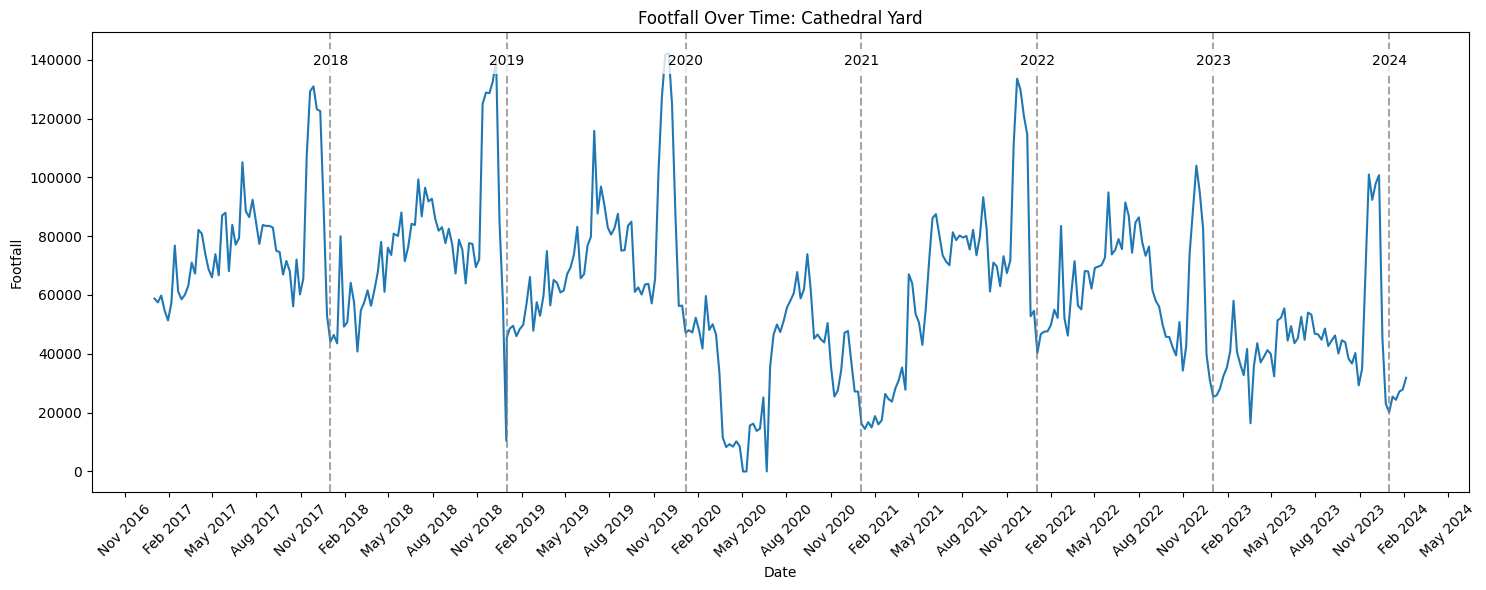

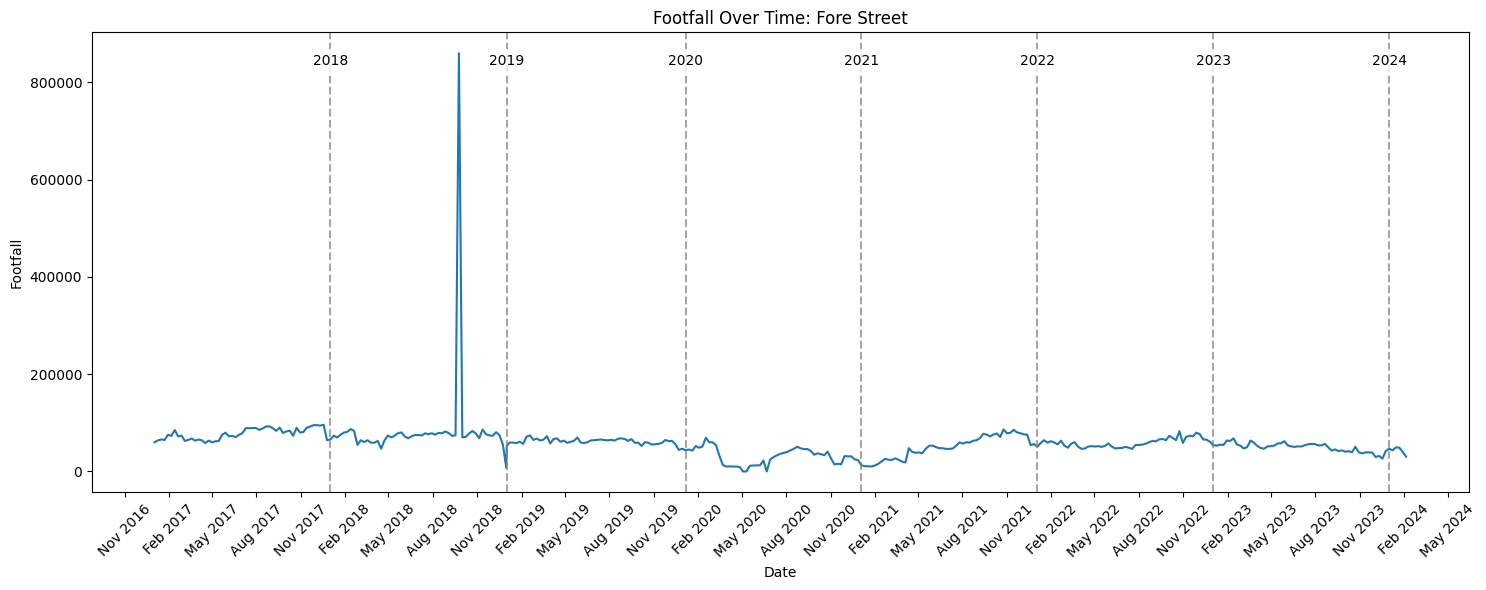

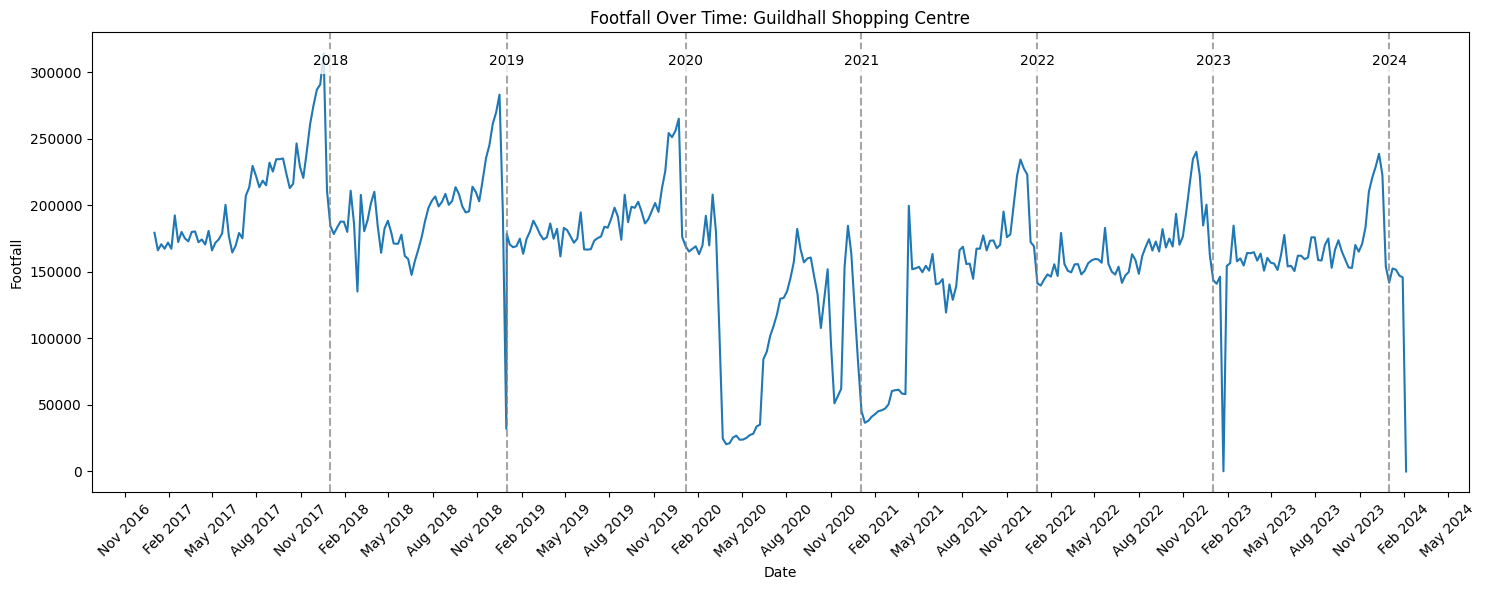

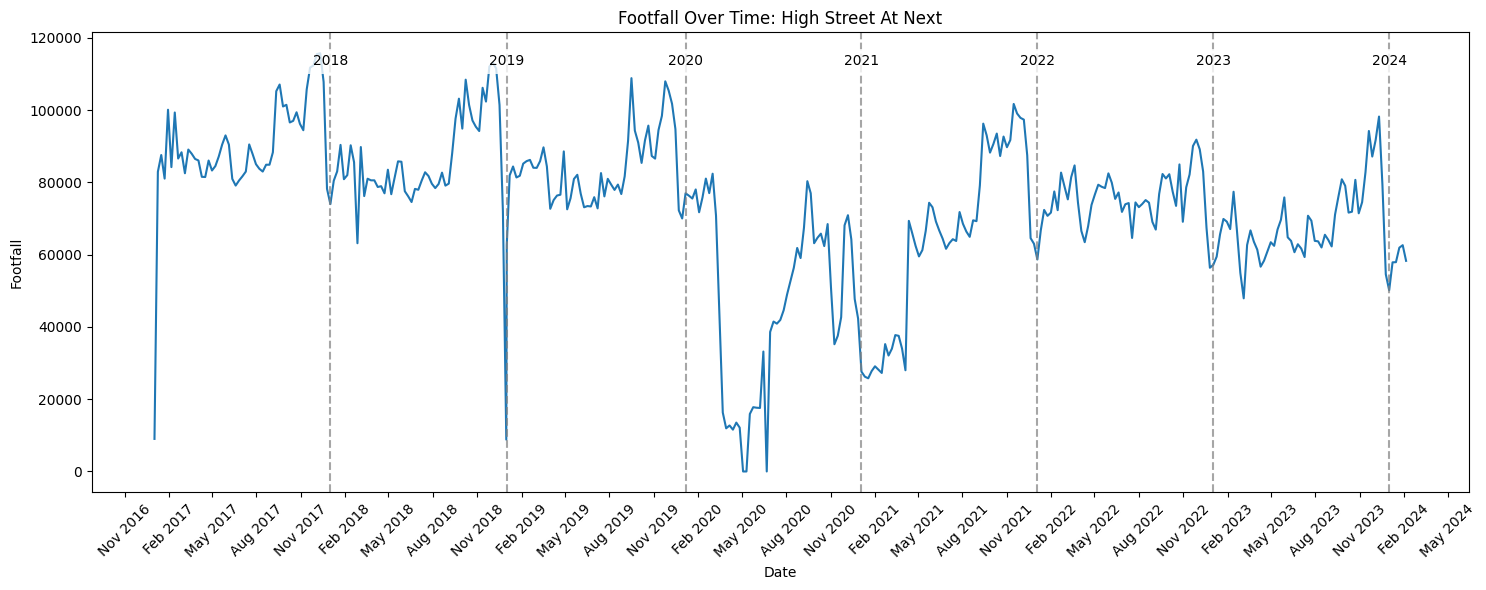

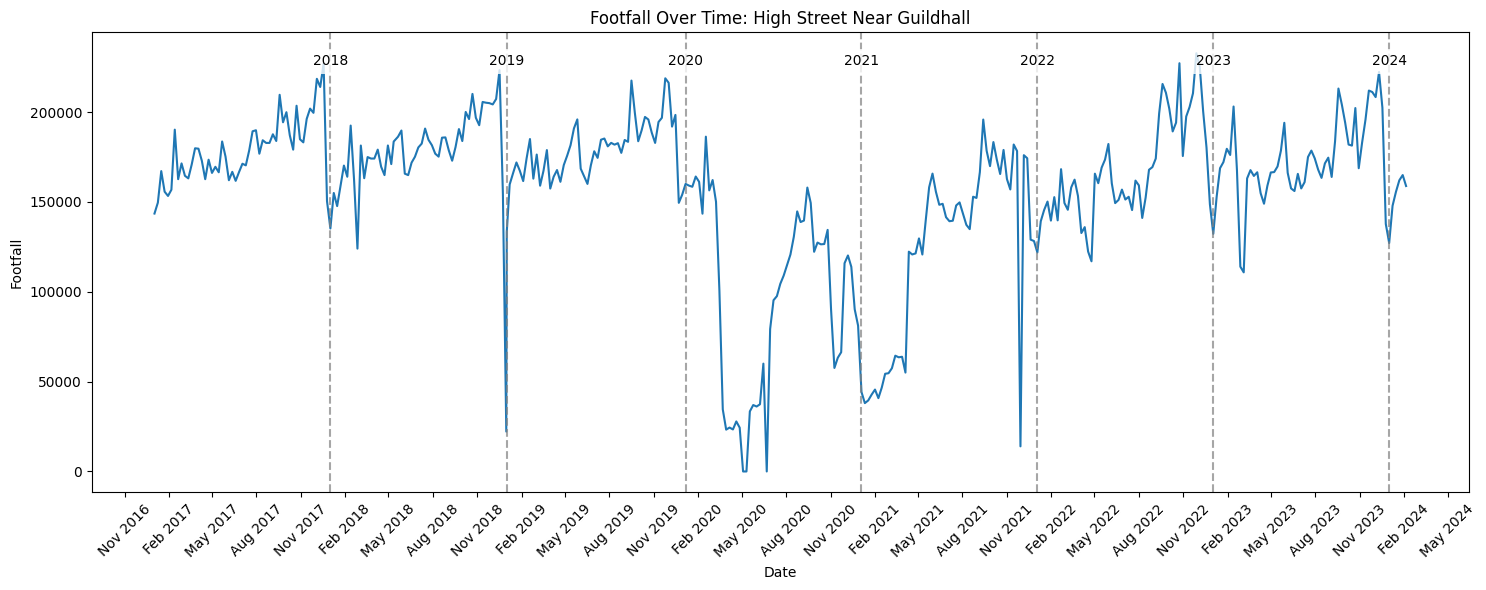

In [31]:
# 4. visual trend line

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
import numpy as np

def plot_footfall_by_location(df):
    """
    Create line charts showing footfall over time for each location,
    with vertical dashed lines at year changes.

    Parameters:
    df (pandas.DataFrame): DataFrame with columns 'Location', 'Date', 'Footfall', and 'Year'
    """
    # Get unique locations
    locations = df['Location'].unique()

    # Create a figure for each location
    for location in locations:
        # Filter data for the current location
        location_data = df[df['Location'] == location].sort_values('Date')

        # Create figure and axis
        plt.figure(figsize=(15, 6))
        ax = plt.gca()

        # Plot footfall over time - no markers
        plt.plot(location_data['Date'], location_data['Footfall'], linestyle='-')

        # Find where years change
        year_changes = []
        years = []
        for i in range(1, len(location_data)):
            if location_data.iloc[i]['Year'] != location_data.iloc[i-1]['Year']:
                year_changes.append(location_data.iloc[i]['Date'])
                years.append(location_data.iloc[i]['Year'])

        # Add vertical lines at year changes
        for i, date in enumerate(year_changes):
            plt.axvline(x=date, color='gray', linestyle='--', alpha=0.7)
            plt.text(date, plt.ylim()[1]*0.95, str(years[i]),
                     horizontalalignment='center', verticalalignment='top',
                     bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

        # Format the x-axis with dates
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Show every 3 months
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        plt.xticks(rotation=45)

        # Add labels and title
        plt.xlabel('Date')
        plt.ylabel('Footfall')
        plt.title(f'Footfall Over Time: {location}')

        # Removed the grid lines
        plt.grid(False)

        # Add some padding to the layout
        plt.tight_layout()

        # Show the plot
        plt.show()

# Run the visualization function on your data
plot_footfall_by_location(longform_footfall_with_covid_period_df)

5. Clearly there is a mistake in Forestreet as mentioned priously that number is wild. For now i will mark it as not there and create a column for outliers.

In [32]:
# 5. Add new column to deal with forestreet, it will be adjusted footfall
def add_adjusted_footfall_columns(df):
    """
    Add columns:
    - Adjusted_Footfall: a copy of Footfall
    - is_outlier: with default value 'not_outlier'
    - was_footfall_adjusted: with default value 'not_adjusted'

    Parameters:
    df (pandas.DataFrame): DataFrame with a 'Footfall' column

    Returns:
    pandas.DataFrame: DataFrame with the added columns
    """
    # Create a copy of the DataFrame to avoid modifying the original
    modified_df = df.copy()

    # Add the new columns
    modified_df['Adjusted_Footfall'] = modified_df['Footfall']
    modified_df['is_outlier'] = 'not_outlier'
    modified_df['was_footfall_adjusted'] = 'not_adjusted'

    return modified_df

# Add the new columns to your DataFrame
longform_footfall_with_covid_period_df = add_adjusted_footfall_columns(longform_footfall_with_covid_period_df)

# Verify the new columns were added
print(longform_footfall_with_covid_period_df.head())
print(longform_footfall_with_covid_period_df.info())

          Location       Date  Footfall     missing_data_check  is_missing  \
0   Cathedral Yard 2017-01-02     58776  footfall_data_present           0   
5   Cathedral Yard 2017-01-09     57491  footfall_data_present           0   
10  Cathedral Yard 2017-01-16     59805  footfall_data_present           0   
15  Cathedral Yard 2017-01-23     54700  footfall_data_present           0   
20  Cathedral Yard 2017-01-30     51341  footfall_data_present           0   

    Year    covid_time_period  location_date_index  Adjusted_Footfall  \
0   2017  pre_pandemic_period                    1              58776   
5   2017  pre_pandemic_period                    2              57491   
10  2017  pre_pandemic_period                    3              59805   
15  2017  pre_pandemic_period                    4              54700   
20  2017  pre_pandemic_period                    5              51341   

     is_outlier was_footfall_adjusted  
0   not_outlier          not_adjusted  
5   not_outl

In [33]:
# 5.  Filter data for Forestreet
forestreet_data = longform_footfall_with_covid_period_df[longform_footfall_with_covid_period_df['Location'] == 'Fore Street']

# Find the maximum footfall
max_footfall = forestreet_data['Footfall'].max()

# Get the date of the maximum footfall
max_date = forestreet_data[forestreet_data['Footfall'] == max_footfall]['Date'].values[0]

# Print the results
print(f"Maximum footfall for Forestreet: {max_footfall}")
print(f"Date of maximum footfall: {max_date}")

Maximum footfall for Forestreet: 859907
Date of maximum footfall: 2018-09-24T00:00:00.000000000


In [34]:
# 5. Filter data for Fore Street
forestreet_data = longform_footfall_with_covid_period_df[longform_footfall_with_covid_period_df['Location'] == 'Fore Street']

# Sort by date
forestreet_data = forestreet_data.sort_values('Date')

# Find the maximum footfall
max_footfall = forestreet_data['Footfall'].max()

# Get the row with the maximum footfall
max_row = forestreet_data[forestreet_data['Footfall'] == max_footfall].iloc[0]
max_date = max_row['Date']

# Find the previous date
previous_date_row = forestreet_data[forestreet_data['Date'] < max_date].iloc[-1]

# Find the next date
next_date_row = forestreet_data[forestreet_data['Date'] > max_date].iloc[0]

# Print the results
print(f"Maximum footfall for Fore Street: {max_footfall}")
print(f"Date of maximum footfall: {max_date}")
print(f"Previous date: {previous_date_row['Date']}")
print(f"Footfall on previous date: {previous_date_row['Footfall']}")
print(f"Next date: {next_date_row['Date']}")
print(f"Footfall on next date: {next_date_row['Footfall']}")

Maximum footfall for Fore Street: 859907
Date of maximum footfall: 2018-09-24 00:00:00
Previous date: 2018-09-17 00:00:00
Footfall on previous date: 74520
Next date: 2018-10-01 00:00:00
Footfall on next date: 70371


In [35]:
# 5. replace with average of previos and past data
a = round((74520+70371)/2)
print(a)

72446


In [36]:
# 5. replace the value on the adjusted footfall

# Find the specific row for Fore Street on the given date
mask = (longform_footfall_with_covid_period_df['Location'] == 'Fore Street') & (longform_footfall_with_covid_period_df['Date'] == '2018-09-24 00:00:00')

# Make the requested changes
longform_footfall_with_covid_period_df.loc[mask, 'is_outlier'] = "is_outlier"
longform_footfall_with_covid_period_df.loc[mask, 'was_footfall_adjusted'] = "footfall_adjusted"
longform_footfall_with_covid_period_df.loc[mask, 'Adjusted_Footfall'] = 72446

# Verify the changes
print(longform_footfall_with_covid_period_df.loc[mask])

        Location       Date  Footfall     missing_data_check  is_missing  \
451  Fore Street 2018-09-24    859907  footfall_data_present           0   

     Year    covid_time_period  location_date_index  Adjusted_Footfall  \
451  2018  pre_pandemic_period                   91              72446   

     is_outlier was_footfall_adjusted  
451  is_outlier     footfall_adjusted  


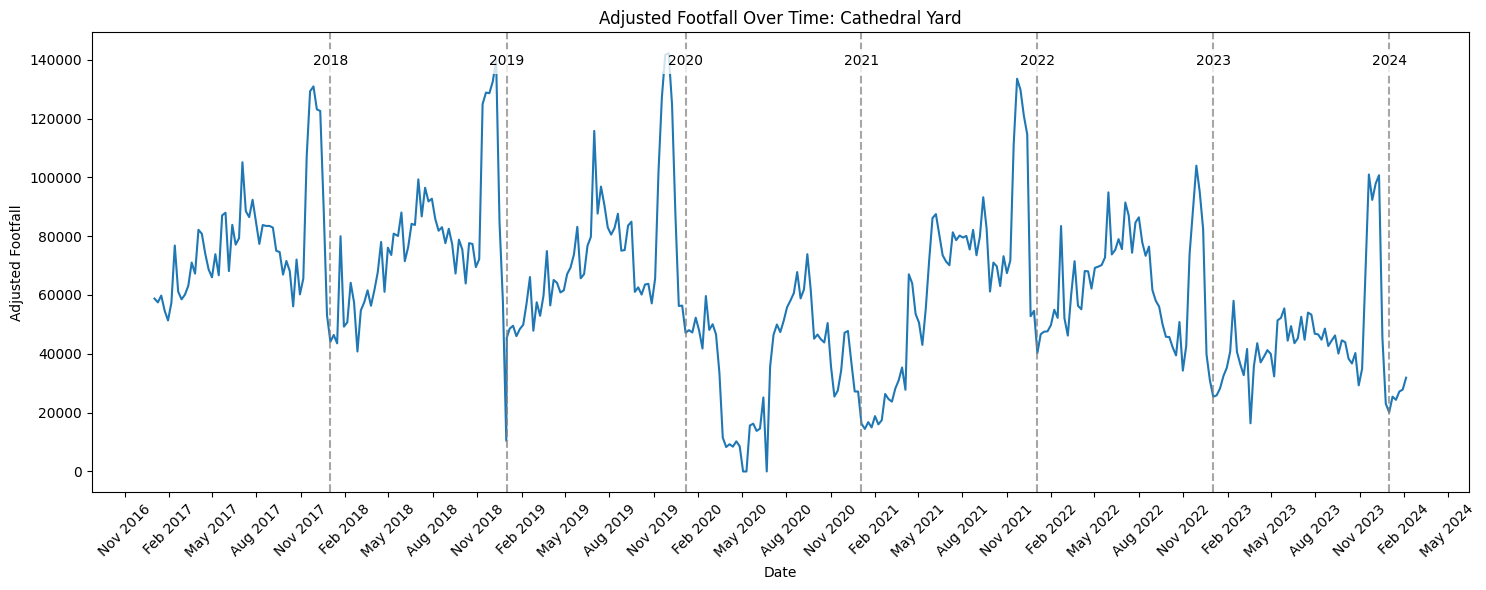

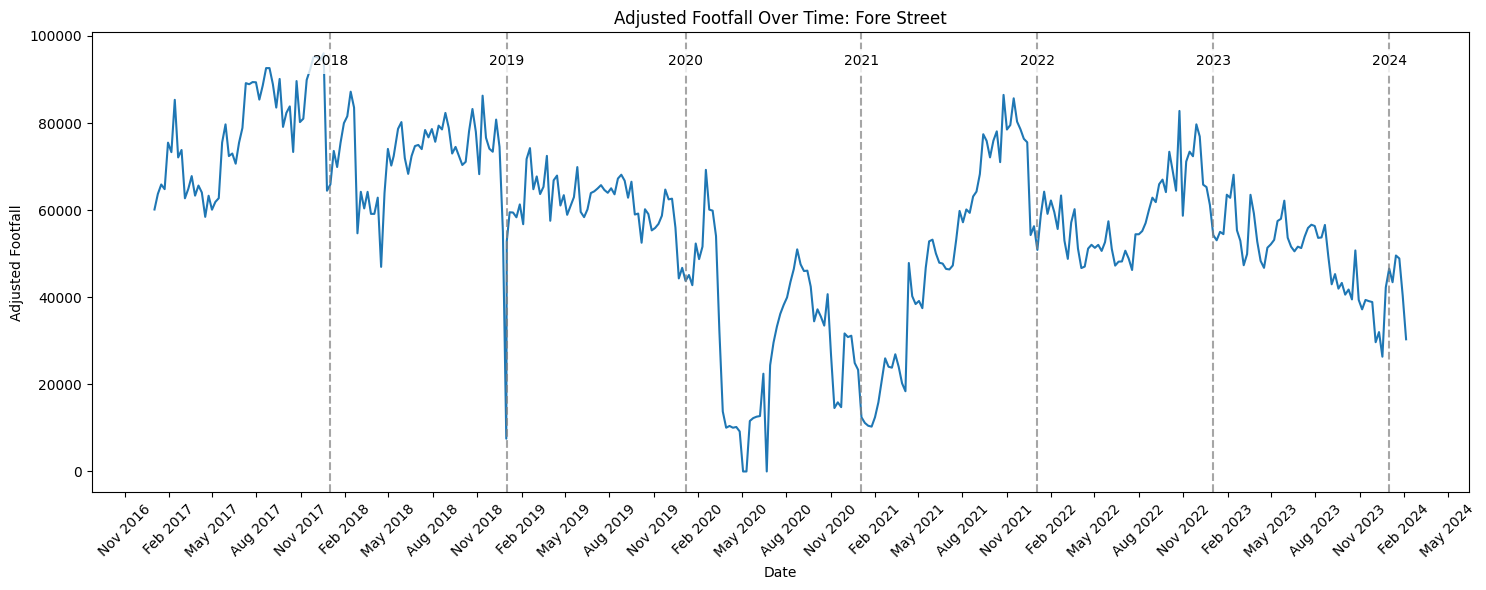

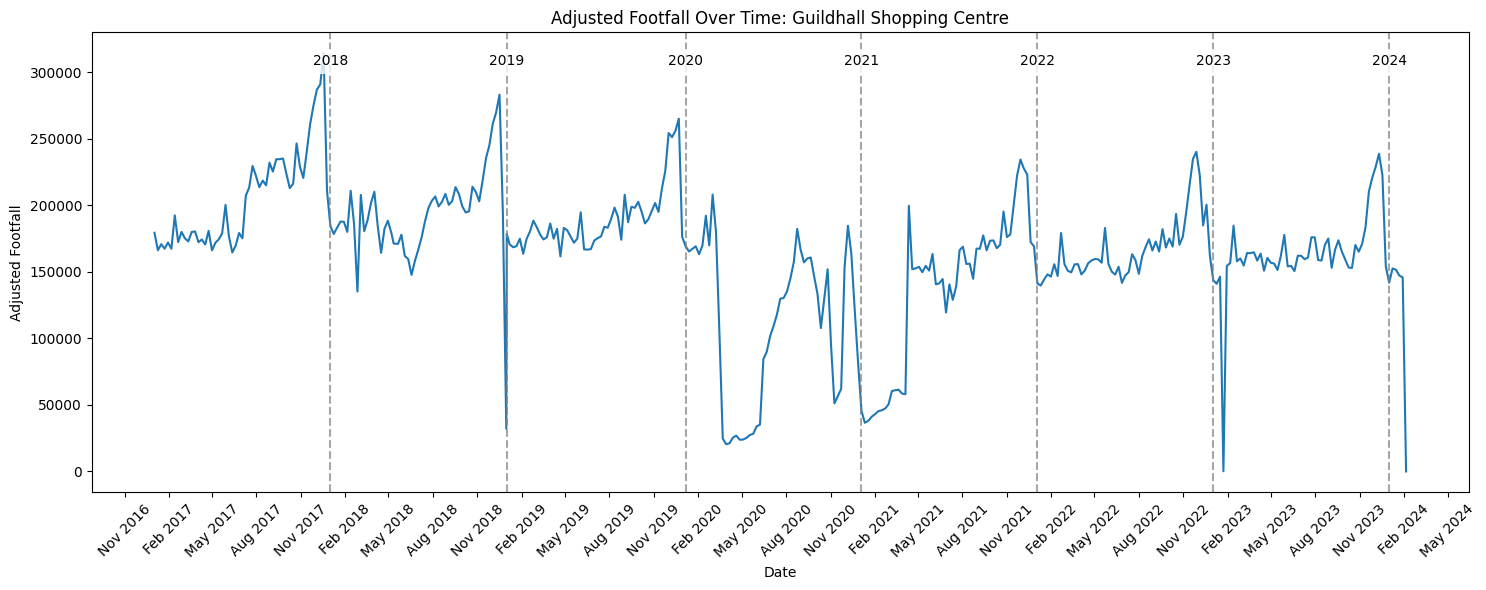

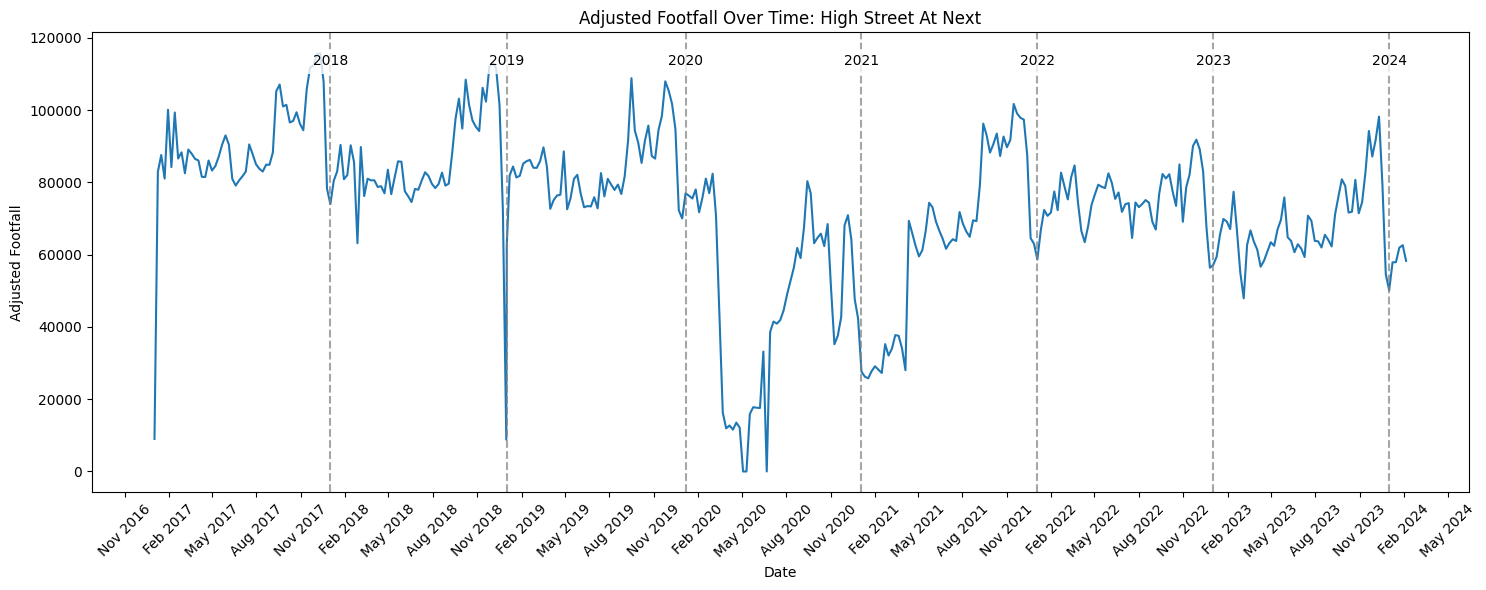

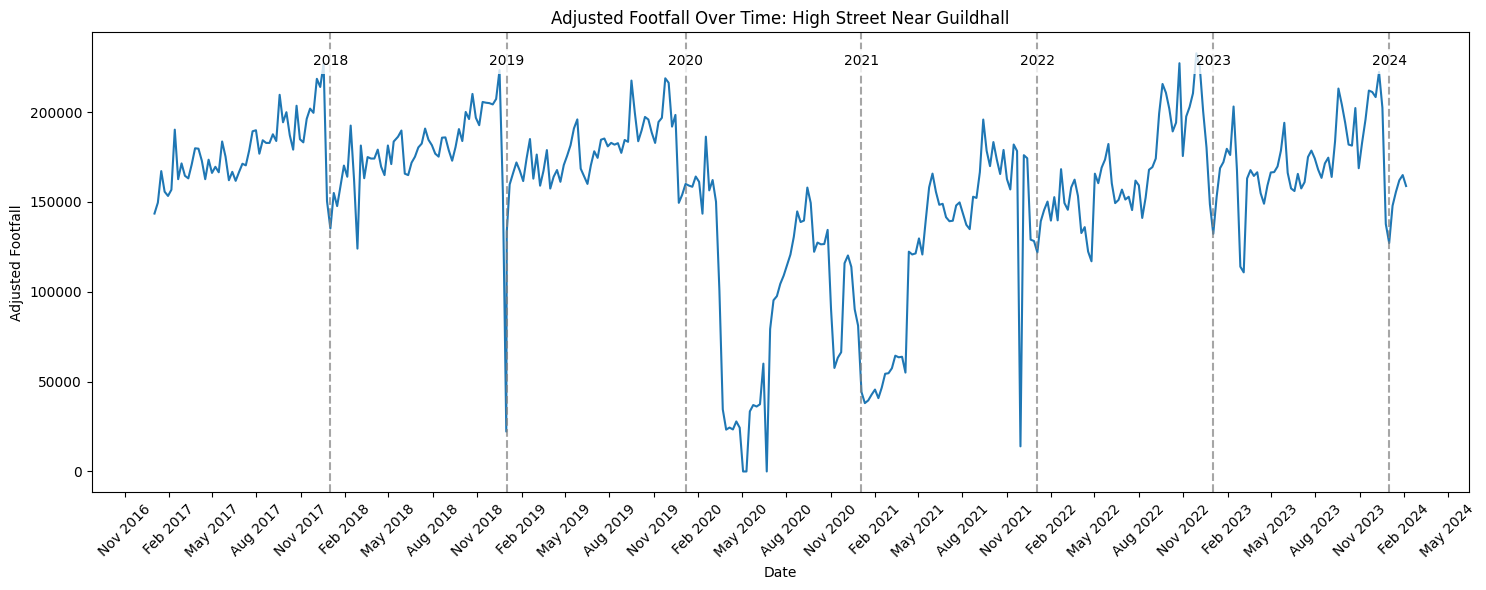

In [37]:
# 5. With forestreeet change

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
import numpy as np

def plot_footfall_by_location(df):
    """
    Create line charts showing adjusted footfall over time for each location,
    with vertical dashed lines at year changes.

    Parameters:
    df (pandas.DataFrame): DataFrame with columns 'Location', 'Date', 'Adjusted_Footfall', and 'Year'
    """
    # Get unique locations
    locations = df['Location'].unique()

    # Create a figure for each location
    for location in locations:
        # Filter data for the current location
        location_data = df[df['Location'] == location].sort_values('Date')

        # Create figure and axis
        plt.figure(figsize=(15, 6))
        ax = plt.gca()

        # Plot adjusted footfall over time - no markers
        # CHANGED: Using Adjusted_Footfall instead of Footfall
        plt.plot(location_data['Date'], location_data['Adjusted_Footfall'], linestyle='-')

        # Find where years change
        year_changes = []
        years = []
        for i in range(1, len(location_data)):
            if location_data.iloc[i]['Year'] != location_data.iloc[i-1]['Year']:
                year_changes.append(location_data.iloc[i]['Date'])
                years.append(location_data.iloc[i]['Year'])

        # Add vertical lines at year changes
        for i, date in enumerate(year_changes):
            plt.axvline(x=date, color='gray', linestyle='--', alpha=0.7)
            plt.text(date, plt.ylim()[1]*0.95, str(years[i]),
                     horizontalalignment='center', verticalalignment='top',
                     bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

        # Format the x-axis with dates
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Show every 3 months
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        plt.xticks(rotation=45)

        # Add labels and title
        plt.xlabel('Date')
        # CHANGED: Updated y-axis label to Adjusted Footfall
        plt.ylabel('Adjusted Footfall')
        # CHANGED: Updated title to reflect Adjusted Footfall
        plt.title(f'Adjusted Footfall Over Time: {location}')

        # Removed the grid lines
        plt.grid(False)

        # Add some padding to the layout
        plt.tight_layout()

        # Show the plot
        plt.show()

# Run the visualization function on your data
plot_footfall_by_location(longform_footfall_with_covid_period_df)

In [38]:
# 5. Any missing values
# Filter the DataFrame for rows where missing_data_check = "footfall_data_is_missing"
missing_data_rows = longform_footfall_with_covid_period_df[longform_footfall_with_covid_period_df['missing_data_check'] == "footfall_data_is_missing"]

# Display the results
from IPython.display import display
display(missing_data_rows)

,Location,Date,Footfall,missing_data_check,is_missing,Year,covid_time_period,location_date_index,Adjusted_Footfall,is_outlier,was_footfall_adjusted
1857,Guildhall Shopping Centre,2024-02-05,0,footfall_data_is_missing,1,2024,post_pandemic_period,372,0,not_outlier,not_adjusted


In [39]:
# 5. Display the ammount of data points:

# Calculate the number of data points for each location
location_counts = longform_footfall_with_covid_period_df['Location'].value_counts()

# Display the results with display() function
from IPython.display import display

print("Total data points for each location:")
display(location_counts)

# As a DataFrame with a more descriptive column name
location_counts_df = location_counts.reset_index()
location_counts_df.columns = ['Location', 'Data Points']



Total data points for each location:


,count
Location,
Cathedral Yard,372
Fore Street,372
Guildhall Shopping Centre,372
High Street At Next,372
High Street Near Guildhall,372


In [40]:
# 5. we are going to do a rolling window data analysis with a two year window 104 weeks and a step of 26 weeks
a = 372 - 104
b = a%26
print(a)
print(b)

268
8


I need the window and and step to leave no remainder i currently have 8 remainder. I will disregard point 372 as guildhall has a missing value, and the first 7 points. (Window 104 and step will be 26)

In [41]:
#5.  print detail
print(longform_footfall_with_covid_period_df.info())
display(longform_footfall_with_covid_period_df.head(1))

<class 'pandas.core.frame.DataFrame'>
Index: 1860 entries, 0 to 1859
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Location               1860 non-null   object        
 1   Date                   1860 non-null   datetime64[ns]
 2   Footfall               1860 non-null   int64         
 3   missing_data_check     1860 non-null   object        
 4   is_missing             1860 non-null   int64         
 5   Year                   1860 non-null   int32         
 6   covid_time_period      1860 non-null   object        
 7   location_date_index    1860 non-null   int64         
 8   Adjusted_Footfall      1860 non-null   int64         
 9   is_outlier             1860 non-null   object        
 10  was_footfall_adjusted  1860 non-null   object        
dtypes: datetime64[ns](1), int32(1), int64(4), object(5)
memory usage: 167.1+ KB
None


,Location,Date,Footfall,missing_data_check,is_missing,Year,covid_time_period,location_date_index,Adjusted_Footfall,is_outlier,was_footfall_adjusted
0,Cathedral Yard,2017-01-02,58776,footfall_data_present,0,2017,pre_pandemic_period,1,58776,not_outlier,not_adjusted


In [42]:
#5.  Drop all rows where location_date_index equals 1, 2, 3, 4, 5, 6, 7, or 372
indices_to_drop = [1, 2, 3, 4, 5, 6, 7, 372]
filtered_df = longform_footfall_with_covid_period_df[~longform_footfall_with_covid_period_df['location_date_index'].isin(indices_to_drop)]

# Verify the shape of the new DataFrame (should have 8 fewer rows)
print(f"Original DataFrame shape: {longform_footfall_with_covid_period_df.shape}")
print(f"Filtered DataFrame shape: {filtered_df.shape}")

Original DataFrame shape: (1860, 11)
Filtered DataFrame shape: (1820, 11)


In [43]:
#5.  Drop the specified columns and update the original DataFrame in place
columns_to_drop = ['Footfall', 'missing_data_check', 'is_missing',
                   'location_date_index', 'is_outlier', 'was_footfall_adjusted']

longform_footfall_with_covid_period_df.drop(columns=columns_to_drop, inplace=True)

# Verify the updated DataFrame
print(f"Updated DataFrame shape: {longform_footfall_with_covid_period_df.shape}")
print(f"Remaining columns: {longform_footfall_with_covid_period_df.columns.tolist()}")

Updated DataFrame shape: (1860, 5)
Remaining columns: ['Location', 'Date', 'Year', 'covid_time_period', 'Adjusted_Footfall']


In [44]:
#5.  Rename 'Adjusted_Footfall' column to 'Footfall'
longform_footfall_with_covid_period_df = longform_footfall_with_covid_period_df.rename(columns={'Adjusted_Footfall': 'Footfall'})

# To verify the column names have been updated
print(longform_footfall_with_covid_period_df.columns.tolist())

['Location', 'Date', 'Year', 'covid_time_period', 'Footfall']


Will use period based, pre, post and during covid. this should show the difference.


Pre covid to estimate covid
covid to estimate post covid

post covid to estimate covid
covid to estimate precovid

pre to estimate post covid
post to estimate pre covid

then I could compare them all, does that make sense?


Yes, that makes a lot of sense! You're essentially creating a matrix of predictive models and comparisons, which can reveal valuable insights into the impact of COVID-19. Here's a breakdown of why this approach is strong and how to interpret the results:

Why This Approach Is Effective:

Asymmetry of Impact:
You're testing whether the relationships observed in one period can predict behavior in another. This is crucial because COVID-19 likely caused asymmetrical changes. For example, pre-COVID patterns might not accurately predict post-COVID behavior, but some post-COVID patterns might reflect a return to some pre-COVID tendencies.
Testing Model Generalization:
By training on one period and testing on another, you're assessing how well your models generalize across different phases of the pandemic.
Quantifying Change:
By comparing the prediction errors across these different combinations, you can quantify the degree to which COVID-19 disrupted the underlying patterns in your data.
Identifying Persistent Effects:
By comparing the models that estimate pre-covid from post covid, and post covid from pre covid, you can see if the changes caused by covid are persistent, or if the time series returns to its original patterns.

In [45]:
# Create total data frame
# Group by 'Date' and sum the 'Footfall' values
total_footfall_for_analysis = longform_footfall_with_covid_period_df.groupby(['Date', 'Year', 'covid_time_period'])['Footfall'].sum().reset_index()

# Display the first few rows to verify
total_footfall_for_analysis.head()

,Date,Year,covid_time_period,Footfall
0,2017-01-02,2017,pre_pandemic_period,450777
1,2017-01-09,2017,pre_pandemic_period,519923
2,2017-01-16,2017,pre_pandemic_period,551081
3,2017-01-23,2017,pre_pandemic_period,523595
4,2017-01-30,2017,pre_pandemic_period,552206


In [46]:
# Get unique values from the covid_time_period column
unique_periods = longform_footfall_with_covid_period_df['covid_time_period'].unique()

# Print the unique values
print("Unique values in covid_time_period:")
for period in unique_periods:
    print(f"- {period}")

# Count occurrences of each unique value
period_counts = longform_footfall_with_covid_period_df['covid_time_period'].value_counts()
print("\nCounts of each period:")
print(period_counts)

Unique values in covid_time_period:
- pre_pandemic_period
- pandemic_period
- post_pandemic_period

Counts of each period:
covid_time_period
pre_pandemic_period     835
pandemic_period         525
post_pandemic_period    500
Name: count, dtype: int64


In [47]:
# Split into 3 data frames
# First, ensure the Date column is in datetime format (if it's not already)
total_footfall_for_analysis['Date'] = pd.to_datetime(total_footfall_for_analysis['Date'])

# Split into three dataframes based on covid_time_period
total_pre_pandemic_period_df = total_footfall_for_analysis[total_footfall_for_analysis['covid_time_period'] == 'pre_pandemic_period'].copy()
total_pandemic_period_df = total_footfall_for_analysis[total_footfall_for_analysis['covid_time_period'] == 'pandemic_period'].copy()
total_post_pandemic_period_df = total_footfall_for_analysis[total_footfall_for_analysis['covid_time_period'] == 'post_pandemic_period'].copy()

# Sort each dataframe by date (oldest to newest)
total_pre_pandemic_period_df = total_pre_pandemic_period_df.sort_values('Date')
total_pandemic_period_df = total_pandemic_period_df.sort_values('Date')
total_post_pandemic_period_df = total_post_pandemic_period_df.sort_values('Date')

# Reset the indices for clean dataframes
total_pre_pandemic_period_df.reset_index(drop=True, inplace=True)
total_pandemic_period_df.reset_index(drop=True, inplace=True)
total_post_pandemic_period_df.reset_index(drop=True, inplace=True)

# Display the heads of each dataframe to verify
print("Pre-pandemic period dataframe:")
print(total_pre_pandemic_period_df.head())
print("\nPandemic period dataframe:")
print(total_pandemic_period_df.head())
print("\nPost-pandemic period dataframe:")
print(total_post_pandemic_period_df.head())

Pre-pandemic period dataframe:
        Date  Year    covid_time_period  Footfall
0 2017-01-02  2017  pre_pandemic_period    450777
1 2017-01-09  2017  pre_pandemic_period    519923
2 2017-01-16  2017  pre_pandemic_period    551081
3 2017-01-23  2017  pre_pandemic_period    523595
4 2017-01-30  2017  pre_pandemic_period    552206

Pandemic period dataframe:
        Date  Year covid_time_period  Footfall
0 2020-03-09  2020   pandemic_period    501142
1 2020-03-16  2020   pandemic_period    314578
2 2020-03-23  2020   pandemic_period    100826
3 2020-03-30  2020   pandemic_period     74050
4 2020-04-06  2020   pandemic_period     78074

Post-pandemic period dataframe:
        Date  Year     covid_time_period  Footfall
0 2022-03-14  2022  post_pandemic_period    506389
1 2022-03-21  2022  post_pandemic_period    534346
2 2022-03-28  2022  post_pandemic_period    491022
3 2022-04-04  2022  post_pandemic_period    449128
4 2022-04-11  2022  post_pandemic_period    465433


In [48]:
import os

# Define the base directory
BASE_DIR = '/content/drive/My Drive/machine_learning/data_for_assignment/footfall_data/total_footfall'

# Save pre-pandemic data
pre_pandemic_path = os.path.join(BASE_DIR, "summed_location_pre-pandemic.parquet")
total_pre_pandemic_period_df.to_parquet(pre_pandemic_path, index=False)
print(f"Pre-pandemic parquet file saved to: {pre_pandemic_path}")

# Save during-pandemic data
during_pandemic_path = os.path.join(BASE_DIR, "summed_location_during-pandemic.parquet")
total_pandemic_period_df.to_parquet(during_pandemic_path, index=False)
print(f"During-pandemic parquet file saved to: {during_pandemic_path}")

# Save post-pandemic data
post_pandemic_path = os.path.join(BASE_DIR, "summed_location_post-pandemic.parquet")
total_post_pandemic_period_df.to_parquet(post_pandemic_path, index=False)
print(f"Post-pandemic parquet file saved to: {post_pandemic_path}")

Pre-pandemic parquet file saved to: /content/drive/My Drive/machine_learning/data_for_assignment/footfall_data/total_footfall/summed_location_pre-pandemic.parquet
During-pandemic parquet file saved to: /content/drive/My Drive/machine_learning/data_for_assignment/footfall_data/total_footfall/summed_location_during-pandemic.parquet
Post-pandemic parquet file saved to: /content/drive/My Drive/machine_learning/data_for_assignment/footfall_data/total_footfall/summed_location_post-pandemic.parquet
